In [5]:
import sys
import shap 
import pickle
import sklearn 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace 

In [6]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results







In [7]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [17]:

data_name="dd_fix_demo"

estimator_name = "mlp_reg"
to_shuffle = True
to_exclude_at_risk = 0




In [18]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [19]:
configs.specifier = specifier
configs.data_name = data_name



In [20]:

configs.specifier



'dd_fix_demo-mlp_reg--shuffled:True--exclude at risk:0'

# demo-Freg-mm:

- Chosen model: **MLP**



https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

## Load Data

In [21]:

dd = DyslexiaData(path="../../datasets/", n_repeats=5)




In [22]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 


In [23]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,1,177.3,531.8,219.0,1,4,10,23,102.0
1,1,10,4,2,200.5,545.2,247.0,1,4,10,23,102.0
2,1,10,4,3,282.7,542.4,261.0,1,4,10,23,102.0
3,1,10,4,4,358.1,545.5,268.0,1,4,10,23,102.0
4,1,10,4,4,392.8,536.3,129.0,1,4,10,23,102.0


In [24]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [25]:

x_org.head()



,FIX_DURATION,Sex_1,Grade_3,FIX_Y,Sex_2,Grade_2,Grade_5,Grade_6,FIX_X,Age,IQ,Grade_1,Grade_4
0,219.0,1,0,531.8,0,0,0,0,177.3,10,23,0,1
1,247.0,1,0,545.2,0,0,0,0,200.5,10,23,0,1
2,261.0,1,0,542.4,0,0,0,0,282.7,10,23,0,1
3,268.0,1,0,545.5,0,0,0,0,358.1,10,23,0,1
4,129.0,1,0,536.3,0,0,0,0,392.8,10,23,0,1


In [26]:
# for i in range(x_org.Sex_1.values.shape[0]):
#     print(x_org.Sex_1.values[i], x_org.Sex_2.values[i])

In [27]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [28]:


estimator_name = "MLP_reg"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: regression


In [29]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (225350, 13)


In [30]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )



In [32]:

# data



## Load the tuned parameters

In [34]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 158),
             ('max_iter', 49150),
             ('solver', 'lbfgs')])

In [35]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl


MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [36]:
x_train = data["6"]["x_train"]
x_test = data["6"]["x_test"]
y_train = data["6"]["y_train"]
y_test = data["6"]["y_test"]



In [37]:

class_names = ['Norm', 'At-risk', 'Dyslexic']




In [38]:
# from joblib import dump, load


# mdl = load(configs.models_path.joinpath(configs.specifier+".joblib"))
# mdl


In [ ]:

# results = load_a_dict(
#     name=configs.specifier,
#     save_path=configs.results_path,
#         )




# for i in range(1, 11):
#     i = str(i)
#     y_test_ = results[i]["y_test"]
#     y_pred_ = results[i]["y_pred"]
#     y_prob_ = results[i]["y_pred_prob"]
    
#     cm = sklearn.metrics.confusion_matrix(
#     y_true=y_test_, 
#     y_pred=y_pred_
#     )
    
#     disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=class_names
#                              )
#     disp.plot()
#     plt.show()
    
    
#     print(
#         "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
#         "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
#                                                   multi_class="ovr",
#                                                   average="weighted")
#     )





In [ ]:


# print_the_evaluated_results(
#     results=results, 
#     learning_method=learning_method
# )



In [ ]:


mdl.fit(x_train, y_train)




RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        22564     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.86383D+00    |proj g|=  2.04061D-02


 This problem is unconstrained.



At iterate    1    f=  4.65562D+00    |proj g|=  1.40733D-02

At iterate    2    f=  4.38105D+00    |proj g|=  2.50471D-02

At iterate    3    f=  4.20243D+00    |proj g|=  2.53417D-02

At iterate    4    f=  3.96481D+00    |proj g|=  1.47601D-02

At iterate    5    f=  3.80710D+00    |proj g|=  2.24694D-02

At iterate    6    f=  3.71101D+00    |proj g|=  2.06562D-02

At iterate    7    f=  3.64457D+00    |proj g|=  1.31918D-02

At iterate    8    f=  3.56810D+00    |proj g|=  1.29667D-02

At iterate    9    f=  3.51219D+00    |proj g|=  7.19115D-03

At iterate   10    f=  3.42600D+00    |proj g|=  9.19100D-03

At iterate   11    f=  3.37731D+00    |proj g|=  2.07868D-02

At iterate   12    f=  3.32130D+00    |proj g|=  6.40866D-03

At iterate   13    f=  3.28772D+00    |proj g|=  6.66939D-03

At iterate   14    f=  3.25748D+00    |proj g|=  9.91073D-03

At iterate   15    f=  3.21160D+00    |proj g|=  1.67971D-02

At iterate   16    f=  3.16661D+00    |proj g|=  1.65379D-02

At iter


At iterate  134    f=  9.69577D-01    |proj g|=  1.21134D-02

At iterate  135    f=  9.64049D-01    |proj g|=  2.29735D-02

At iterate  136    f=  9.60052D-01    |proj g|=  6.20245D-02

At iterate  137    f=  9.55544D-01    |proj g|=  2.75397D-02

At iterate  138    f=  9.49144D-01    |proj g|=  1.88727D-02

At iterate  139    f=  9.44913D-01    |proj g|=  2.84324D-02

At iterate  140    f=  9.34686D-01    |proj g|=  2.39271D-02

At iterate  141    f=  9.28949D-01    |proj g|=  4.70236D-02

At iterate  142    f=  9.23543D-01    |proj g|=  1.70916D-02

At iterate  143    f=  9.16944D-01    |proj g|=  2.21648D-02

At iterate  144    f=  9.12400D-01    |proj g|=  4.30435D-02

At iterate  145    f=  9.06187D-01    |proj g|=  3.39318D-02

At iterate  146    f=  8.97907D-01    |proj g|=  2.25331D-02

At iterate  147    f=  8.92404D-01    |proj g|=  2.69550D-02

At iterate  148    f=  8.87799D-01    |proj g|=  1.12026D-02

At iterate  149    f=  8.81849D-01    |proj g|=  2.10466D-02

At iter


At iterate  267    f=  6.09013D-01    |proj g|=  6.90083D-03

At iterate  268    f=  6.08100D-01    |proj g|=  8.88526D-03

At iterate  269    f=  6.06868D-01    |proj g|=  7.92686D-03

At iterate  270    f=  6.05750D-01    |proj g|=  1.68043D-02

At iterate  271    f=  6.04317D-01    |proj g|=  4.79188D-03

At iterate  272    f=  6.03432D-01    |proj g|=  5.27584D-03

At iterate  273    f=  6.02262D-01    |proj g|=  4.13808D-03

At iterate  274    f=  6.00777D-01    |proj g|=  2.07035D-02

At iterate  275    f=  5.99315D-01    |proj g|=  1.16314D-02

At iterate  276    f=  5.98306D-01    |proj g|=  7.32644D-03

At iterate  277    f=  5.97554D-01    |proj g|=  7.03834D-03

At iterate  278    f=  5.96856D-01    |proj g|=  1.21450D-02

At iterate  279    f=  5.95954D-01    |proj g|=  4.46514D-03

At iterate  280    f=  5.95134D-01    |proj g|=  3.81301D-03

At iterate  281    f=  5.94070D-01    |proj g|=  7.78131D-03

At iterate  282    f=  5.93506D-01    |proj g|=  1.80791D-02

At iter


At iterate  400    f=  5.35280D-01    |proj g|=  4.38094D-03

At iterate  401    f=  5.35108D-01    |proj g|=  5.04979D-03

At iterate  402    f=  5.34845D-01    |proj g|=  8.45484D-03

At iterate  403    f=  5.34599D-01    |proj g|=  8.52313D-03

At iterate  404    f=  5.34455D-01    |proj g|=  2.50186D-03

At iterate  405    f=  5.34348D-01    |proj g|=  2.06487D-03

At iterate  406    f=  5.34039D-01    |proj g|=  6.14418D-03

At iterate  407    f=  5.33707D-01    |proj g|=  5.49575D-03

At iterate  408    f=  5.33515D-01    |proj g|=  6.21658D-03

At iterate  409    f=  5.33329D-01    |proj g|=  3.16338D-03

At iterate  410    f=  5.33022D-01    |proj g|=  3.83843D-03

At iterate  411    f=  5.32773D-01    |proj g|=  3.30589D-03

At iterate  412    f=  5.32420D-01    |proj g|=  9.58562D-03

At iterate  413    f=  5.32114D-01    |proj g|=  4.91678D-03

At iterate  414    f=  5.31956D-01    |proj g|=  2.32987D-03

At iterate  415    f=  5.31807D-01    |proj g|=  3.44596D-03

At iter


At iterate  533    f=  5.14733D-01    |proj g|=  2.92985D-03

At iterate  534    f=  5.14639D-01    |proj g|=  2.36354D-03

At iterate  535    f=  5.14455D-01    |proj g|=  3.20830D-03

At iterate  536    f=  5.14335D-01    |proj g|=  5.51027D-03

At iterate  537    f=  5.14193D-01    |proj g|=  3.59328D-03

At iterate  538    f=  5.14074D-01    |proj g|=  2.04955D-03

At iterate  539    f=  5.13966D-01    |proj g|=  3.00704D-03

At iterate  540    f=  5.13900D-01    |proj g|=  8.40486D-03

At iterate  541    f=  5.13787D-01    |proj g|=  2.28724D-03

At iterate  542    f=  5.13710D-01    |proj g|=  1.68769D-03

At iterate  543    f=  5.13652D-01    |proj g|=  2.43215D-03

At iterate  544    f=  5.13571D-01    |proj g|=  1.03093D-02

At iterate  545    f=  5.13459D-01    |proj g|=  2.83831D-03

At iterate  546    f=  5.13390D-01    |proj g|=  2.88403D-03

At iterate  547    f=  5.13288D-01    |proj g|=  2.27541D-03

At iterate  548    f=  5.13184D-01    |proj g|=  2.97424D-03

At iter


At iterate  709    f=  5.00759D-01    |proj g|=  1.30353D-03

At iterate  710    f=  5.00726D-01    |proj g|=  1.26171D-03

At iterate  711    f=  5.00673D-01    |proj g|=  6.36181D-03

At iterate  712    f=  5.00618D-01    |proj g|=  2.13651D-03

At iterate  713    f=  5.00586D-01    |proj g|=  1.04056D-03

At iterate  714    f=  5.00551D-01    |proj g|=  1.87066D-03

At iterate  715    f=  5.00487D-01    |proj g|=  2.45374D-03

At iterate  716    f=  5.00419D-01    |proj g|=  6.99588D-03

At iterate  717    f=  5.00340D-01    |proj g|=  3.33351D-03

At iterate  718    f=  5.00290D-01    |proj g|=  2.66681D-03

At iterate  719    f=  5.00223D-01    |proj g|=  2.80790D-03

At iterate  720    f=  5.00189D-01    |proj g|=  7.28430D-03

At iterate  721    f=  5.00115D-01    |proj g|=  2.37563D-03

At iterate  722    f=  5.00048D-01    |proj g|=  1.85073D-03

At iterate  723    f=  4.99992D-01    |proj g|=  2.03476D-03

At iterate  724    f=  4.99932D-01    |proj g|=  8.80765D-03

At iter


At iterate  842    f=  4.94720D-01    |proj g|=  1.41492D-03

At iterate  843    f=  4.94682D-01    |proj g|=  1.90982D-03

At iterate  844    f=  4.94650D-01    |proj g|=  4.42291D-03

At iterate  845    f=  4.94602D-01    |proj g|=  2.00727D-03

At iterate  846    f=  4.94568D-01    |proj g|=  8.72434D-04

At iterate  847    f=  4.94535D-01    |proj g|=  1.48044D-03

At iterate  848    f=  4.94498D-01    |proj g|=  6.99207D-03

At iterate  849    f=  4.94456D-01    |proj g|=  2.62528D-03

At iterate  850    f=  4.94427D-01    |proj g|=  1.36770D-03

At iterate  851    f=  4.94388D-01    |proj g|=  1.36712D-03

At iterate  852    f=  4.94353D-01    |proj g|=  2.13788D-03

At iterate  853    f=  4.94313D-01    |proj g|=  3.95417D-03

At iterate  854    f=  4.94270D-01    |proj g|=  1.25383D-03

At iterate  855    f=  4.94239D-01    |proj g|=  1.54045D-03

At iterate  856    f=  4.94199D-01    |proj g|=  1.74509D-03

At iterate  857    f=  4.94184D-01    |proj g|=  7.73798D-03

At iter


At iterate  975    f=  4.90187D-01    |proj g|=  1.79612D-03

At iterate  976    f=  4.90145D-01    |proj g|=  2.04966D-03

At iterate  977    f=  4.90134D-01    |proj g|=  6.22496D-03

At iterate  978    f=  4.90063D-01    |proj g|=  1.02761D-03

At iterate  979    f=  4.90046D-01    |proj g|=  8.64855D-04

At iterate  980    f=  4.90011D-01    |proj g|=  3.83716D-03

At iterate  981    f=  4.89996D-01    |proj g|=  3.29680D-03

At iterate  982    f=  4.89973D-01    |proj g|=  1.67047D-03

At iterate  983    f=  4.89948D-01    |proj g|=  1.02664D-03

At iterate  984    f=  4.89918D-01    |proj g|=  1.56668D-03

At iterate  985    f=  4.89866D-01    |proj g|=  2.00690D-03

At iterate  986    f=  4.89849D-01    |proj g|=  4.66409D-03

At iterate  987    f=  4.89818D-01    |proj g|=  1.83083D-03

At iterate  988    f=  4.89793D-01    |proj g|=  1.15719D-03

At iterate  989    f=  4.89761D-01    |proj g|=  2.28630D-03

At iterate  990    f=  4.89729D-01    |proj g|=  2.09038D-03

At iter


At iterate 1108    f=  4.86001D-01    |proj g|=  2.91116D-03

At iterate 1109    f=  4.85974D-01    |proj g|=  1.05422D-03

At iterate 1110    f=  4.85951D-01    |proj g|=  1.56527D-03

At iterate 1111    f=  4.85925D-01    |proj g|=  1.70053D-03

At iterate 1112    f=  4.85903D-01    |proj g|=  2.86617D-03

At iterate 1113    f=  4.85868D-01    |proj g|=  1.18082D-03

At iterate 1114    f=  4.85846D-01    |proj g|=  1.20313D-03

At iterate 1115    f=  4.85809D-01    |proj g|=  2.83790D-03

At iterate 1116    f=  4.85774D-01    |proj g|=  1.88240D-03

At iterate 1117    f=  4.85740D-01    |proj g|=  3.73832D-03

At iterate 1118    f=  4.85707D-01    |proj g|=  9.40274D-04

At iterate 1119    f=  4.85686D-01    |proj g|=  1.75502D-03

At iterate 1120    f=  4.85654D-01    |proj g|=  2.91315D-03

At iterate 1121    f=  4.85640D-01    |proj g|=  3.64852D-03

At iterate 1122    f=  4.85620D-01    |proj g|=  1.57083D-03

At iterate 1123    f=  4.85597D-01    |proj g|=  1.58754D-03

At iter


At iterate 1241    f=  4.82147D-01    |proj g|=  2.05189D-03

At iterate 1242    f=  4.82100D-01    |proj g|=  3.32775D-03

At iterate 1243    f=  4.82073D-01    |proj g|=  3.17739D-03

At iterate 1244    f=  4.82041D-01    |proj g|=  1.00214D-03

At iterate 1245    f=  4.82016D-01    |proj g|=  9.14746D-04

At iterate 1246    f=  4.81989D-01    |proj g|=  2.16271D-03

At iterate 1247    f=  4.81971D-01    |proj g|=  5.33118D-03

At iterate 1248    f=  4.81943D-01    |proj g|=  2.99802D-03

At iterate 1249    f=  4.81907D-01    |proj g|=  9.28596D-04

At iterate 1250    f=  4.81881D-01    |proj g|=  1.42613D-03

At iterate 1251    f=  4.81864D-01    |proj g|=  6.08963D-03

At iterate 1252    f=  4.81832D-01    |proj g|=  2.87151D-03

At iterate 1253    f=  4.81798D-01    |proj g|=  1.01008D-03

At iterate 1254    f=  4.81766D-01    |proj g|=  1.38323D-03

At iterate 1255    f=  4.81725D-01    |proj g|=  1.83856D-03

At iterate 1256    f=  4.81662D-01    |proj g|=  3.39303D-03

At iter


At iterate 1374    f=  4.78840D-01    |proj g|=  5.78261D-04

At iterate 1375    f=  4.78832D-01    |proj g|=  8.19307D-04

At iterate 1376    f=  4.78818D-01    |proj g|=  1.37565D-03

At iterate 1377    f=  4.78806D-01    |proj g|=  3.47457D-03

At iterate 1378    f=  4.78785D-01    |proj g|=  1.78236D-03

At iterate 1379    f=  4.78768D-01    |proj g|=  7.54525D-04

At iterate 1380    f=  4.78748D-01    |proj g|=  1.13208D-03

At iterate 1381    f=  4.78720D-01    |proj g|=  3.14888D-03

At iterate 1382    f=  4.78699D-01    |proj g|=  2.84514D-03

At iterate 1383    f=  4.78677D-01    |proj g|=  9.50950D-04

At iterate 1384    f=  4.78661D-01    |proj g|=  9.36868D-04

At iterate 1385    f=  4.78640D-01    |proj g|=  1.16678D-03

At iterate 1386    f=  4.78629D-01    |proj g|=  3.72131D-03

At iterate 1387    f=  4.78605D-01    |proj g|=  2.04818D-03

At iterate 1388    f=  4.78583D-01    |proj g|=  7.18898D-04

At iterate 1389    f=  4.78560D-01    |proj g|=  1.70263D-03

At iter


At iterate 1507    f=  4.76224D-01    |proj g|=  5.63503D-03

At iterate 1508    f=  4.76206D-01    |proj g|=  1.29258D-03

At iterate 1509    f=  4.76193D-01    |proj g|=  1.41163D-03

At iterate 1510    f=  4.76178D-01    |proj g|=  2.54566D-03

At iterate 1511    f=  4.76146D-01    |proj g|=  2.82668D-03

At iterate 1512    f=  4.76133D-01    |proj g|=  3.39698D-03

At iterate 1513    f=  4.76114D-01    |proj g|=  1.01458D-03

At iterate 1514    f=  4.76098D-01    |proj g|=  1.12216D-03

At iterate 1515    f=  4.76079D-01    |proj g|=  2.57349D-03

At iterate 1516    f=  4.76050D-01    |proj g|=  3.12984D-03

At iterate 1517    f=  4.76039D-01    |proj g|=  3.20890D-03

At iterate 1518    f=  4.76012D-01    |proj g|=  1.52743D-03

At iterate 1519    f=  4.75990D-01    |proj g|=  7.25286D-04

At iterate 1520    f=  4.75967D-01    |proj g|=  4.56510D-03

At iterate 1521    f=  4.75947D-01    |proj g|=  1.68150D-03

At iterate 1522    f=  4.75935D-01    |proj g|=  8.55369D-04

At iter


At iterate 1640    f=  4.73760D-01    |proj g|=  9.09031D-04

At iterate 1641    f=  4.73744D-01    |proj g|=  9.97336D-04

At iterate 1642    f=  4.73730D-01    |proj g|=  3.17033D-03

At iterate 1643    f=  4.73709D-01    |proj g|=  1.27381D-03

At iterate 1644    f=  4.73694D-01    |proj g|=  1.00382D-03

At iterate 1645    f=  4.73674D-01    |proj g|=  1.16948D-03

At iterate 1646    f=  4.73653D-01    |proj g|=  2.40939D-03

At iterate 1647    f=  4.73636D-01    |proj g|=  3.40288D-03

At iterate 1648    f=  4.73616D-01    |proj g|=  9.93244D-04

At iterate 1649    f=  4.73601D-01    |proj g|=  1.23687D-03

At iterate 1650    f=  4.73585D-01    |proj g|=  1.95401D-03

At iterate 1651    f=  4.73573D-01    |proj g|=  6.15375D-03

At iterate 1652    f=  4.73547D-01    |proj g|=  1.01430D-03

At iterate 1653    f=  4.73532D-01    |proj g|=  1.71776D-03

At iterate 1654    f=  4.73513D-01    |proj g|=  2.06958D-03

At iterate 1655    f=  4.73476D-01    |proj g|=  3.90416D-03

At iter


At iterate 1773    f=  4.71713D-01    |proj g|=  7.05574D-04

At iterate 1774    f=  4.71702D-01    |proj g|=  1.31035D-03

At iterate 1775    f=  4.71687D-01    |proj g|=  1.46261D-03

At iterate 1776    f=  4.71676D-01    |proj g|=  4.14106D-03

At iterate 1777    f=  4.71656D-01    |proj g|=  1.51189D-03

At iterate 1778    f=  4.71645D-01    |proj g|=  5.61662D-04

At iterate 1779    f=  4.71633D-01    |proj g|=  2.51808D-03

At iterate 1780    f=  4.71622D-01    |proj g|=  1.49732D-03

At iterate 1781    f=  4.71610D-01    |proj g|=  9.72657D-04

At iterate 1782    f=  4.71588D-01    |proj g|=  1.52890D-03

At iterate 1783    f=  4.71584D-01    |proj g|=  3.85886D-03

At iterate 1784    f=  4.71568D-01    |proj g|=  8.81920D-04

At iterate 1785    f=  4.71560D-01    |proj g|=  7.21156D-04

At iterate 1786    f=  4.71546D-01    |proj g|=  1.21398D-03

At iterate 1787    f=  4.71532D-01    |proj g|=  4.27974D-03

At iterate 1788    f=  4.71513D-01    |proj g|=  1.60519D-03

At iter


At iterate 1906    f=  4.70174D-01    |proj g|=  1.89819D-03

At iterate 1907    f=  4.70164D-01    |proj g|=  1.24875D-03

At iterate 1908    f=  4.70156D-01    |proj g|=  9.65693D-04

At iterate 1909    f=  4.70148D-01    |proj g|=  1.13968D-03

At iterate 1910    f=  4.70139D-01    |proj g|=  8.94993D-04

At iterate 1911    f=  4.70124D-01    |proj g|=  8.59119D-04

At iterate 1912    f=  4.70120D-01    |proj g|=  3.22417D-03

At iterate 1913    f=  4.70111D-01    |proj g|=  8.86849D-04

At iterate 1914    f=  4.70106D-01    |proj g|=  7.30487D-04

At iterate 1915    f=  4.70096D-01    |proj g|=  1.28641D-03

At iterate 1916    f=  4.70090D-01    |proj g|=  2.88663D-03

At iterate 1917    f=  4.70078D-01    |proj g|=  8.59947D-04

At iterate 1918    f=  4.70072D-01    |proj g|=  5.56284D-04

At iterate 1919    f=  4.70066D-01    |proj g|=  7.48608D-04

At iterate 1920    f=  4.70055D-01    |proj g|=  1.04720D-03

At iterate 1921    f=  4.70047D-01    |proj g|=  2.90904D-03

At iter


At iterate 2039    f=  4.68812D-01    |proj g|=  3.21355D-03

At iterate 2040    f=  4.68802D-01    |proj g|=  1.46778D-03

At iterate 2041    f=  4.68787D-01    |proj g|=  1.11932D-03

At iterate 2042    f=  4.68777D-01    |proj g|=  1.66531D-03

At iterate 2043    f=  4.68750D-01    |proj g|=  2.08418D-03

At iterate 2044    f=  4.68737D-01    |proj g|=  2.36447D-03

At iterate 2045    f=  4.68724D-01    |proj g|=  7.84261D-04

At iterate 2046    f=  4.68711D-01    |proj g|=  8.51169D-04

At iterate 2047    f=  4.68696D-01    |proj g|=  3.79974D-03

At iterate 2048    f=  4.68676D-01    |proj g|=  2.27142D-03

At iterate 2049    f=  4.68658D-01    |proj g|=  2.00192D-03

At iterate 2050    f=  4.68643D-01    |proj g|=  6.64026D-04

At iterate 2051    f=  4.68633D-01    |proj g|=  1.35483D-03

At iterate 2052    f=  4.68622D-01    |proj g|=  4.58224D-03

At iterate 2053    f=  4.68610D-01    |proj g|=  1.09698D-03

At iterate 2054    f=  4.68602D-01    |proj g|=  5.39077D-04

At iter


At iterate 2172    f=  4.67289D-01    |proj g|=  7.04172D-04

At iterate 2173    f=  4.67280D-01    |proj g|=  9.61279D-04

At iterate 2174    f=  4.67268D-01    |proj g|=  2.04963D-03

At iterate 2175    f=  4.67255D-01    |proj g|=  1.94843D-03

At iterate 2176    f=  4.67243D-01    |proj g|=  8.34361D-04

At iterate 2177    f=  4.67232D-01    |proj g|=  7.55986D-04

At iterate 2178    f=  4.67222D-01    |proj g|=  1.24075D-03

At iterate 2179    f=  4.67213D-01    |proj g|=  5.66138D-03

At iterate 2180    f=  4.67198D-01    |proj g|=  9.02672D-04

At iterate 2181    f=  4.67192D-01    |proj g|=  6.77144D-04

At iterate 2182    f=  4.67183D-01    |proj g|=  7.64208D-04

At iterate 2183    f=  4.67170D-01    |proj g|=  2.08258D-03

At iterate 2184    f=  4.67157D-01    |proj g|=  2.37594D-03

At iterate 2185    f=  4.67146D-01    |proj g|=  8.24650D-04

At iterate 2186    f=  4.67133D-01    |proj g|=  9.90517D-04

At iterate 2187    f=  4.67124D-01    |proj g|=  1.24811D-03

At iter


At iterate 2305    f=  4.65702D-01    |proj g|=  9.31995D-04

At iterate 2306    f=  4.65685D-01    |proj g|=  1.36706D-03

At iterate 2307    f=  4.65674D-01    |proj g|=  1.55675D-03

At iterate 2308    f=  4.65658D-01    |proj g|=  9.07747D-04

At iterate 2309    f=  4.65648D-01    |proj g|=  4.44513D-03

At iterate 2310    f=  4.65636D-01    |proj g|=  1.19486D-03

At iterate 2311    f=  4.65627D-01    |proj g|=  7.63551D-04

At iterate 2312    f=  4.65615D-01    |proj g|=  1.82576D-03

At iterate 2313    f=  4.65600D-01    |proj g|=  2.62571D-03

At iterate 2314    f=  4.65590D-01    |proj g|=  4.12264D-03

At iterate 2315    f=  4.65576D-01    |proj g|=  6.83507D-04

At iterate 2316    f=  4.65569D-01    |proj g|=  1.34961D-03

At iterate 2317    f=  4.65560D-01    |proj g|=  1.55535D-03

At iterate 2318    f=  4.65539D-01    |proj g|=  1.78961D-03

At iterate 2319    f=  4.65528D-01    |proj g|=  3.39694D-03

At iterate 2320    f=  4.65511D-01    |proj g|=  8.72985D-04

At iter


At iterate 2438    f=  4.64165D-01    |proj g|=  2.14987D-03

At iterate 2439    f=  4.64153D-01    |proj g|=  3.37212D-03

At iterate 2440    f=  4.64142D-01    |proj g|=  1.09788D-03

At iterate 2441    f=  4.64131D-01    |proj g|=  1.66316D-03

At iterate 2442    f=  4.64125D-01    |proj g|=  2.11124D-03

At iterate 2443    f=  4.64110D-01    |proj g|=  2.94378D-03

At iterate 2444    f=  4.64102D-01    |proj g|=  1.41251D-03

At iterate 2445    f=  4.64095D-01    |proj g|=  6.98103D-04

At iterate 2446    f=  4.64086D-01    |proj g|=  2.25287D-03

At iterate 2447    f=  4.64080D-01    |proj g|=  1.24558D-03

At iterate 2448    f=  4.64070D-01    |proj g|=  7.79329D-04

At iterate 2449    f=  4.64055D-01    |proj g|=  1.79989D-03

At iterate 2450    f=  4.64044D-01    |proj g|=  1.98197D-03

At iterate 2451    f=  4.64034D-01    |proj g|=  9.91433D-04

At iterate 2452    f=  4.64023D-01    |proj g|=  7.90117D-04

At iterate 2453    f=  4.64013D-01    |proj g|=  1.16688D-03

At iter


At iterate 2571    f=  4.62654D-01    |proj g|=  2.19716D-03

At iterate 2572    f=  4.62644D-01    |proj g|=  2.59058D-03

At iterate 2573    f=  4.62635D-01    |proj g|=  1.45531D-03

At iterate 2574    f=  4.62619D-01    |proj g|=  6.15204D-04

At iterate 2575    f=  4.62608D-01    |proj g|=  2.05945D-03

At iterate 2576    f=  4.62594D-01    |proj g|=  1.85464D-03

At iterate 2577    f=  4.62584D-01    |proj g|=  1.06144D-03

At iterate 2578    f=  4.62568D-01    |proj g|=  3.34802D-03

At iterate 2579    f=  4.62556D-01    |proj g|=  1.50118D-03

At iterate 2580    f=  4.62549D-01    |proj g|=  7.71857D-04

At iterate 2581    f=  4.62540D-01    |proj g|=  5.26995D-04

At iterate 2582    f=  4.62533D-01    |proj g|=  8.81535D-04

At iterate 2583    f=  4.62525D-01    |proj g|=  4.63497D-03

At iterate 2584    f=  4.62513D-01    |proj g|=  7.12287D-04

At iterate 2585    f=  4.62508D-01    |proj g|=  9.63796D-04

At iterate 2586    f=  4.62500D-01    |proj g|=  8.59986D-04

At iter


At iterate 2704    f=  4.61304D-01    |proj g|=  7.92533D-04

At iterate 2705    f=  4.61296D-01    |proj g|=  1.12555D-03

At iterate 2706    f=  4.61283D-01    |proj g|=  2.04761D-03

At iterate 2707    f=  4.61274D-01    |proj g|=  1.81600D-03

At iterate 2708    f=  4.61268D-01    |proj g|=  8.65269D-04

At iterate 2709    f=  4.61263D-01    |proj g|=  1.04321D-03

At iterate 2710    f=  4.61258D-01    |proj g|=  1.78150D-03

At iterate 2711    f=  4.61250D-01    |proj g|=  8.55988D-04

At iterate 2712    f=  4.61243D-01    |proj g|=  5.41893D-04

At iterate 2713    f=  4.61234D-01    |proj g|=  1.54802D-03

At iterate 2714    f=  4.61227D-01    |proj g|=  2.20171D-03

At iterate 2715    f=  4.61219D-01    |proj g|=  9.38360D-04

At iterate 2716    f=  4.61210D-01    |proj g|=  7.87177D-04

At iterate 2717    f=  4.61204D-01    |proj g|=  9.68219D-04

At iterate 2718    f=  4.61185D-01    |proj g|=  1.59535D-03

At iterate 2719    f=  4.61181D-01    |proj g|=  2.03928D-03

At iter


At iterate 2837    f=  4.60080D-01    |proj g|=  8.00708D-04

At iterate 2838    f=  4.60071D-01    |proj g|=  2.36007D-03

At iterate 2839    f=  4.60062D-01    |proj g|=  9.40623D-04

At iterate 2840    f=  4.60054D-01    |proj g|=  1.26385D-03

At iterate 2841    f=  4.60044D-01    |proj g|=  2.52658D-03

At iterate 2842    f=  4.60038D-01    |proj g|=  1.70315D-03

At iterate 2843    f=  4.60031D-01    |proj g|=  7.29435D-04

At iterate 2844    f=  4.60024D-01    |proj g|=  8.19795D-04

At iterate 2845    f=  4.60016D-01    |proj g|=  1.20030D-03

At iterate 2846    f=  4.60001D-01    |proj g|=  1.67787D-03

At iterate 2847    f=  4.59996D-01    |proj g|=  1.47264D-03

At iterate 2848    f=  4.59987D-01    |proj g|=  4.41630D-04

At iterate 2849    f=  4.59980D-01    |proj g|=  6.63743D-04

At iterate 2850    f=  4.59971D-01    |proj g|=  1.54560D-03

At iterate 2851    f=  4.59962D-01    |proj g|=  1.63260D-03

At iterate 2852    f=  4.59955D-01    |proj g|=  7.36246D-04

At iter


At iterate 3010    f=  4.58748D-01    |proj g|=  9.30252D-04

At iterate 3011    f=  4.58740D-01    |proj g|=  1.44862D-03

At iterate 3012    f=  4.58732D-01    |proj g|=  9.87895D-04

At iterate 3013    f=  4.58727D-01    |proj g|=  6.65050D-04

At iterate 3014    f=  4.58717D-01    |proj g|=  7.66385D-04

At iterate 3015    f=  4.58709D-01    |proj g|=  2.70788D-03

At iterate 3016    f=  4.58701D-01    |proj g|=  1.19888D-03

At iterate 3017    f=  4.58695D-01    |proj g|=  6.57970D-04

At iterate 3018    f=  4.58690D-01    |proj g|=  8.03719D-04

At iterate 3019    f=  4.58682D-01    |proj g|=  2.19480D-03

At iterate 3020    f=  4.58673D-01    |proj g|=  1.25143D-03

At iterate 3021    f=  4.58668D-01    |proj g|=  5.69448D-04

At iterate 3022    f=  4.58661D-01    |proj g|=  4.81877D-04

At iterate 3023    f=  4.58654D-01    |proj g|=  1.74498D-03

At iterate 3024    f=  4.58645D-01    |proj g|=  1.01623D-03

At iterate 3025    f=  4.58638D-01    |proj g|=  1.07868D-03

At iter


At iterate 3143    f=  4.57760D-01    |proj g|=  1.15429D-03

At iterate 3144    f=  4.57751D-01    |proj g|=  9.80445D-04

At iterate 3145    f=  4.57745D-01    |proj g|=  2.91042D-03

At iterate 3146    f=  4.57736D-01    |proj g|=  6.66672D-04

At iterate 3147    f=  4.57733D-01    |proj g|=  6.93371D-04

At iterate 3148    f=  4.57724D-01    |proj g|=  1.21938D-03

At iterate 3149    f=  4.57715D-01    |proj g|=  1.75023D-03

At iterate 3150    f=  4.57706D-01    |proj g|=  7.67553D-04

At iterate 3151    f=  4.57700D-01    |proj g|=  8.31613D-04

At iterate 3152    f=  4.57694D-01    |proj g|=  1.54072D-03

At iterate 3153    f=  4.57688D-01    |proj g|=  9.51561D-04

At iterate 3154    f=  4.57678D-01    |proj g|=  8.72173D-04

At iterate 3155    f=  4.57667D-01    |proj g|=  1.30513D-03

At iterate 3156    f=  4.57660D-01    |proj g|=  2.53342D-03

At iterate 3157    f=  4.57651D-01    |proj g|=  7.91048D-04

At iterate 3158    f=  4.57644D-01    |proj g|=  7.06910D-04

At iter


At iterate 3284    f=  4.56831D-01    |proj g|=  5.03564D-04

At iterate 3285    f=  4.56824D-01    |proj g|=  1.32733D-03

At iterate 3286    f=  4.56816D-01    |proj g|=  2.26057D-03

At iterate 3287    f=  4.56807D-01    |proj g|=  1.27622D-03

At iterate 3288    f=  4.56798D-01    |proj g|=  9.02908D-04

At iterate 3289    f=  4.56794D-01    |proj g|=  4.04289D-03

At iterate 3290    f=  4.56786D-01    |proj g|=  1.21006D-03

At iterate 3291    f=  4.56780D-01    |proj g|=  8.34310D-04

At iterate 3292    f=  4.56771D-01    |proj g|=  1.90724D-03

At iterate 3293    f=  4.56762D-01    |proj g|=  1.61074D-03

At iterate 3294    f=  4.56756D-01    |proj g|=  2.66807D-03

At iterate 3295    f=  4.56747D-01    |proj g|=  7.74047D-04

At iterate 3296    f=  4.56741D-01    |proj g|=  4.45784D-04

At iterate 3297    f=  4.56734D-01    |proj g|=  1.02850D-03

At iterate 3298    f=  4.56725D-01    |proj g|=  1.65650D-03

At iterate 3299    f=  4.56719D-01    |proj g|=  2.17057D-03

At iter


At iterate 3417    f=  4.55974D-01    |proj g|=  7.08892D-04

At iterate 3418    f=  4.55966D-01    |proj g|=  5.97486D-04

At iterate 3419    f=  4.55959D-01    |proj g|=  1.42090D-03

At iterate 3420    f=  4.55951D-01    |proj g|=  1.18358D-03

At iterate 3421    f=  4.55944D-01    |proj g|=  9.57475D-04

At iterate 3422    f=  4.55938D-01    |proj g|=  3.81923D-03

At iterate 3423    f=  4.55929D-01    |proj g|=  9.12175D-04

At iterate 3424    f=  4.55925D-01    |proj g|=  1.27730D-03

At iterate 3425    f=  4.55915D-01    |proj g|=  1.49588D-03

At iterate 3426    f=  4.55913D-01    |proj g|=  1.56464D-03

At iterate 3427    f=  4.55909D-01    |proj g|=  7.40392D-04

At iterate 3428    f=  4.55902D-01    |proj g|=  1.23920D-03

At iterate 3429    f=  4.55893D-01    |proj g|=  1.32136D-03

At iterate 3430    f=  4.55886D-01    |proj g|=  3.48299D-03

At iterate 3431    f=  4.55877D-01    |proj g|=  1.00179D-03

At iterate 3432    f=  4.55871D-01    |proj g|=  8.12061D-04

At iter


At iterate 3550    f=  4.55034D-01    |proj g|=  7.00358D-04

At iterate 3551    f=  4.55026D-01    |proj g|=  1.70542D-03

At iterate 3552    f=  4.55018D-01    |proj g|=  1.12264D-03

At iterate 3553    f=  4.55012D-01    |proj g|=  6.01503D-04

At iterate 3554    f=  4.55007D-01    |proj g|=  5.78383D-04

At iterate 3555    f=  4.55004D-01    |proj g|=  4.29825D-03

At iterate 3556    f=  4.54996D-01    |proj g|=  1.51030D-03

At iterate 3557    f=  4.54989D-01    |proj g|=  1.00683D-03

At iterate 3558    f=  4.54985D-01    |proj g|=  1.46006D-03

At iterate 3559    f=  4.54976D-01    |proj g|=  1.51865D-03

At iterate 3560    f=  4.54971D-01    |proj g|=  1.77423D-03

At iterate 3561    f=  4.54965D-01    |proj g|=  5.28673D-04

At iterate 3562    f=  4.54960D-01    |proj g|=  5.35165D-04

At iterate 3563    f=  4.54954D-01    |proj g|=  1.13367D-03

At iterate 3564    f=  4.54946D-01    |proj g|=  2.35025D-03

At iterate 3565    f=  4.54938D-01    |proj g|=  9.53749D-04

At iter


At iterate 3683    f=  4.54199D-01    |proj g|=  6.73828D-04

At iterate 3684    f=  4.54194D-01    |proj g|=  9.74787D-04

At iterate 3685    f=  4.54187D-01    |proj g|=  2.00711D-03

At iterate 3686    f=  4.54181D-01    |proj g|=  9.51057D-04

At iterate 3687    f=  4.54177D-01    |proj g|=  3.90245D-04

At iterate 3688    f=  4.54172D-01    |proj g|=  7.91239D-04

At iterate 3689    f=  4.54169D-01    |proj g|=  1.76416D-03

At iterate 3690    f=  4.54164D-01    |proj g|=  9.61403D-04

At iterate 3691    f=  4.54157D-01    |proj g|=  4.89787D-04

At iterate 3692    f=  4.54153D-01    |proj g|=  7.63830D-04

At iterate 3693    f=  4.54147D-01    |proj g|=  1.34360D-03

At iterate 3694    f=  4.54142D-01    |proj g|=  6.34335D-04

At iterate 3695    f=  4.54139D-01    |proj g|=  7.94378D-04

At iterate 3696    f=  4.54133D-01    |proj g|=  9.49359D-04

At iterate 3697    f=  4.54127D-01    |proj g|=  2.37428D-03

At iterate 3698    f=  4.54120D-01    |proj g|=  7.73644D-04

At iter


At iterate 3816    f=  4.53465D-01    |proj g|=  7.84180D-04

At iterate 3817    f=  4.53462D-01    |proj g|=  1.29503D-03

At iterate 3818    f=  4.53456D-01    |proj g|=  5.11648D-04

At iterate 3819    f=  4.53451D-01    |proj g|=  4.31613D-04

At iterate 3820    f=  4.53446D-01    |proj g|=  1.26693D-03

At iterate 3821    f=  4.53441D-01    |proj g|=  9.64060D-04

At iterate 3822    f=  4.53437D-01    |proj g|=  6.42817D-04

At iterate 3823    f=  4.53432D-01    |proj g|=  4.45058D-04

At iterate 3824    f=  4.53424D-01    |proj g|=  1.57098D-03

At iterate 3825    f=  4.53416D-01    |proj g|=  1.95861D-03

At iterate 3826    f=  4.53411D-01    |proj g|=  1.09956D-03

At iterate 3827    f=  4.53408D-01    |proj g|=  5.82821D-04

At iterate 3828    f=  4.53403D-01    |proj g|=  6.39020D-04

At iterate 3829    f=  4.53396D-01    |proj g|=  1.53063D-03

At iterate 3830    f=  4.53388D-01    |proj g|=  1.16836D-03

At iterate 3831    f=  4.53380D-01    |proj g|=  1.00538D-03

At iter


At iterate 3949    f=  4.52737D-01    |proj g|=  5.83244D-04

At iterate 3950    f=  4.52733D-01    |proj g|=  6.92498D-04

At iterate 3951    f=  4.52728D-01    |proj g|=  8.62958D-04

At iterate 3952    f=  4.52719D-01    |proj g|=  1.95860D-03

At iterate 3953    f=  4.52711D-01    |proj g|=  1.84382D-03

At iterate 3954    f=  4.52706D-01    |proj g|=  1.06378D-03

At iterate 3955    f=  4.52703D-01    |proj g|=  1.30788D-03

At iterate 3956    f=  4.52696D-01    |proj g|=  1.35742D-03

At iterate 3957    f=  4.52691D-01    |proj g|=  2.28428D-03

At iterate 3958    f=  4.52683D-01    |proj g|=  5.93918D-04

At iterate 3959    f=  4.52679D-01    |proj g|=  3.38879D-04

At iterate 3960    f=  4.52672D-01    |proj g|=  1.49558D-03

At iterate 3961    f=  4.52668D-01    |proj g|=  1.98810D-03

At iterate 3962    f=  4.52664D-01    |proj g|=  7.30076D-04

At iterate 3963    f=  4.52661D-01    |proj g|=  6.31927D-04

At iterate 3964    f=  4.52658D-01    |proj g|=  8.88195D-04

At iter


At iterate 4082    f=  4.52080D-01    |proj g|=  1.59241D-03

At iterate 4083    f=  4.52076D-01    |proj g|=  5.03696D-04

At iterate 4084    f=  4.52071D-01    |proj g|=  5.52846D-04

At iterate 4085    f=  4.52067D-01    |proj g|=  9.60649D-04

At iterate 4086    f=  4.52059D-01    |proj g|=  2.48338D-03

At iterate 4087    f=  4.52054D-01    |proj g|=  1.63129D-03

At iterate 4088    f=  4.52050D-01    |proj g|=  3.05785D-04

At iterate 4089    f=  4.52047D-01    |proj g|=  5.91171D-04

At iterate 4090    f=  4.52043D-01    |proj g|=  1.20591D-03

At iterate 4091    f=  4.52041D-01    |proj g|=  3.53836D-03

At iterate 4092    f=  4.52035D-01    |proj g|=  9.11354D-04

At iterate 4093    f=  4.52033D-01    |proj g|=  6.92559D-04

At iterate 4094    f=  4.52030D-01    |proj g|=  7.88373D-04

At iterate 4095    f=  4.52025D-01    |proj g|=  8.89340D-04

At iterate 4096    f=  4.52022D-01    |proj g|=  1.76155D-03

At iterate 4097    f=  4.52016D-01    |proj g|=  1.01360D-03

At iter


At iterate 4215    f=  4.51514D-01    |proj g|=  1.60838D-03

At iterate 4216    f=  4.51509D-01    |proj g|=  1.08474D-03

At iterate 4217    f=  4.51505D-01    |proj g|=  3.80673D-04

At iterate 4218    f=  4.51501D-01    |proj g|=  8.09232D-04

At iterate 4219    f=  4.51497D-01    |proj g|=  1.46156D-03

At iterate 4220    f=  4.51492D-01    |proj g|=  9.31458D-04

At iterate 4221    f=  4.51486D-01    |proj g|=  2.17651D-03

At iterate 4222    f=  4.51480D-01    |proj g|=  1.10685D-03

At iterate 4223    f=  4.51477D-01    |proj g|=  5.94001D-04

At iterate 4224    f=  4.51473D-01    |proj g|=  8.89836D-04

At iterate 4225    f=  4.51470D-01    |proj g|=  1.70575D-03

At iterate 4226    f=  4.51467D-01    |proj g|=  1.01684D-03

At iterate 4227    f=  4.51462D-01    |proj g|=  2.96010D-04

At iterate 4228    f=  4.51457D-01    |proj g|=  6.55906D-04

At iterate 4229    f=  4.51455D-01    |proj g|=  2.12263D-03

At iterate 4230    f=  4.51449D-01    |proj g|=  4.80817D-04

At iter


At iterate 4348    f=  4.50904D-01    |proj g|=  3.30894D-04

At iterate 4349    f=  4.50902D-01    |proj g|=  4.94976D-04

At iterate 4350    f=  4.50898D-01    |proj g|=  1.02825D-03

At iterate 4351    f=  4.50896D-01    |proj g|=  2.63505D-03

At iterate 4352    f=  4.50889D-01    |proj g|=  6.55195D-04

At iterate 4353    f=  4.50886D-01    |proj g|=  4.40419D-04

At iterate 4354    f=  4.50882D-01    |proj g|=  8.03159D-04

At iterate 4355    f=  4.50878D-01    |proj g|=  2.65463D-03

At iterate 4356    f=  4.50871D-01    |proj g|=  9.39915D-04

At iterate 4357    f=  4.50867D-01    |proj g|=  5.40076D-04

At iterate 4358    f=  4.50861D-01    |proj g|=  1.08672D-03

At iterate 4359    f=  4.50857D-01    |proj g|=  9.35390D-04

At iterate 4360    f=  4.50852D-01    |proj g|=  5.37882D-04

At iterate 4361    f=  4.50846D-01    |proj g|=  1.17812D-03

At iterate 4362    f=  4.50843D-01    |proj g|=  1.00294D-03

At iterate 4363    f=  4.50841D-01    |proj g|=  3.89903D-04

At iter


At iterate 4481    f=  4.50415D-01    |proj g|=  6.76321D-04

At iterate 4482    f=  4.50412D-01    |proj g|=  5.29629D-04

At iterate 4483    f=  4.50409D-01    |proj g|=  7.45136D-04

At iterate 4484    f=  4.50403D-01    |proj g|=  1.18761D-03

At iterate 4485    f=  4.50400D-01    |proj g|=  1.42031D-03

At iterate 4486    f=  4.50396D-01    |proj g|=  2.92980D-04

At iterate 4487    f=  4.50394D-01    |proj g|=  4.81162D-04

At iterate 4488    f=  4.50391D-01    |proj g|=  8.22692D-04

At iterate 4489    f=  4.50389D-01    |proj g|=  2.76909D-03

At iterate 4490    f=  4.50383D-01    |proj g|=  6.24182D-04

At iterate 4491    f=  4.50381D-01    |proj g|=  4.10620D-04

At iterate 4492    f=  4.50378D-01    |proj g|=  6.73753D-04

At iterate 4493    f=  4.50372D-01    |proj g|=  1.21013D-03

At iterate 4494    f=  4.50370D-01    |proj g|=  2.14186D-03

At iterate 4495    f=  4.50365D-01    |proj g|=  6.15117D-04

At iterate 4496    f=  4.50362D-01    |proj g|=  3.33128D-04

At iter

In [45]:

print("model fitted")



model fitted


In [46]:
mdl.predict_proba(x_test[5:10:, :])




array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [47]:
mdl.predict(x_test[5:10:, :])



array([102., 102., 102., 102., 102.])

In [50]:


len(list(x_org.columns)) == x_test.shape[1]




True

In [54]:
explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))



In [55]:


shap_values = explainer(x_test)




Permutation explainer: 22536it [1:25:17,  4.40it/s]                                                                                                                  


In [56]:


print("Shap values are determined!")



Shap values are determined!


In [57]:


y_test.shape, x_test.shape, shap_values.values.shape



((22535,), (22535, 13), (22535, 13))

- what does row explain?  sorted features' importance in ascending order, low to high.
- what does each dot explain? data points
- what does color explain? data points per feature value

Interpret: 

- 

In [ ]:
# shap.summary_plot(shap_values, 
#                   x_test, 
#                   plot_type="bar", 
#                   class_names=class_names, 
#                   feature_names=list(x_org.columns),
#                   alpha=0.1,
#                   color_bar=True,
#                   color_bar_label=True
#                  )



### Shap bar plot



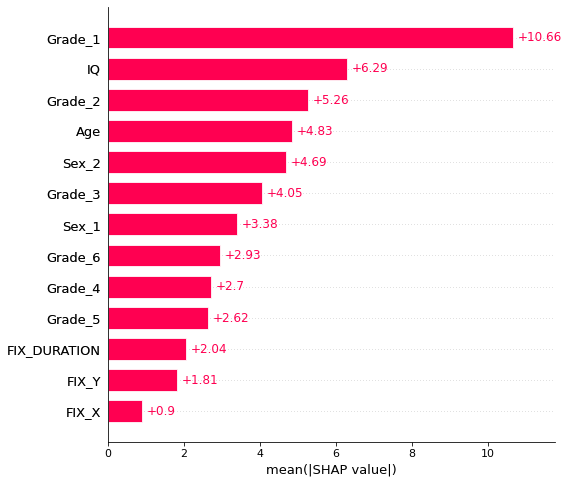

In [58]:

shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")




- The bar plot above depicgts the Mean Absolute SHAP (MAS) values for each feature across the entire data. MAS, on average, quantifies, the magnitude of each feature's contribution towards the predicted class labels. The higher the MAS value for a a feature the more influential that feature is.


- The gender SHAP values sums up to 0.35 turning it two one of the most influentioal features. 
- IQ, Age and the third and fourth grades are the other important features in predicing the class labels.



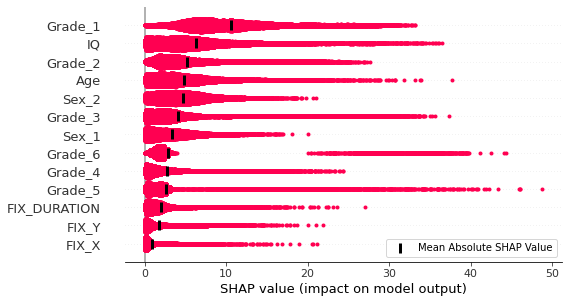

In [65]:
plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")



##### Beeswarm-bar plot: 

- 

### SHAP Summary Plots


Permutation importance numerically measures the importance of features. This simplifies the comparison between features.  However, the considered interaction between features during the features importance determination process, as can be considered a severe drawback of this method. SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 




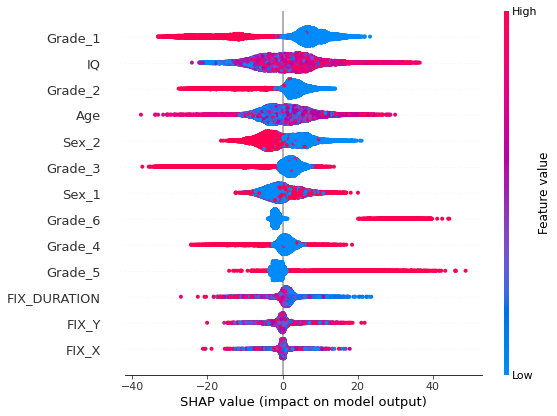

In [66]:
shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )



### SHAP Dependence Contribution Plots

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.


- Each dot is a single prediction (row) from the dataset.
- The x-axis is the actual value from the dataset.
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.

FixedFormatter should only be used together with FixedLocator


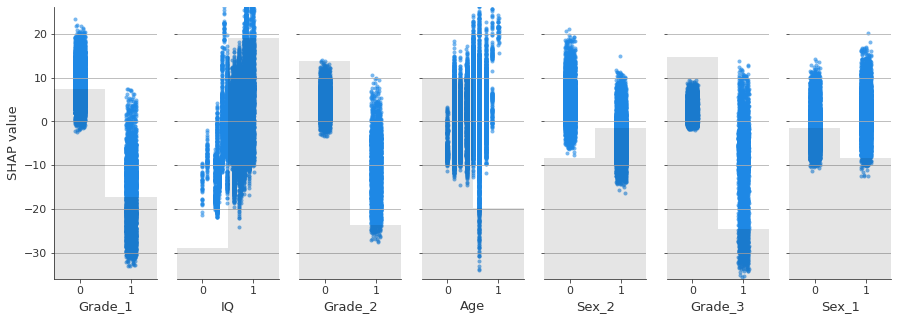

In [67]:
n = 7
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")

In [68]:
# n = 5
# fig, ax = plt.subplots(1, n, figsize=(15, 5))

# for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
#     if i < n:
#         shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
#         ax[i].grid(axis="y")
#         if i != 0:
#             ax[i].set_ylabel("")
#             ax[i].spines["left"].set_visible(False)
#             ax[i].set_ylim(ax[0].get_ylim())
#             ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
#         else:
#             ax[i].set_ylabel("SHAP value")
# # fig.savefig("plots/scatter_top5.png")

##### Dependece plots:

- 


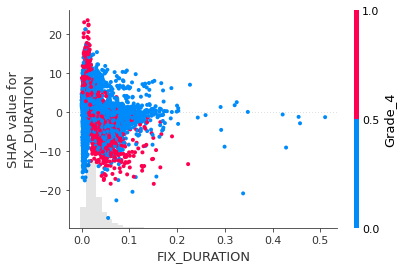

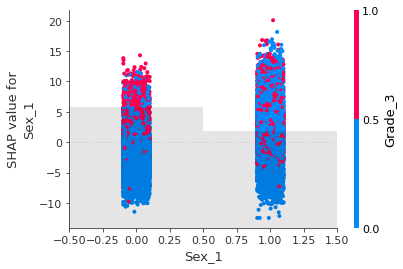

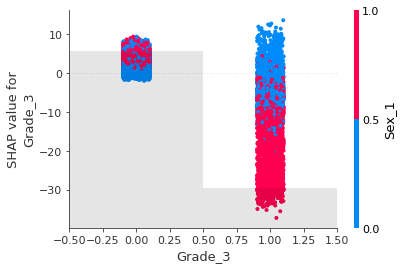

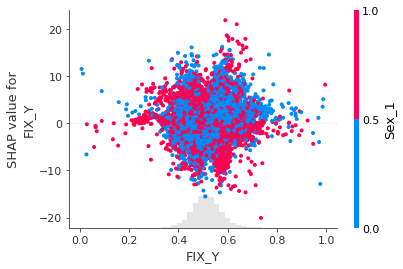

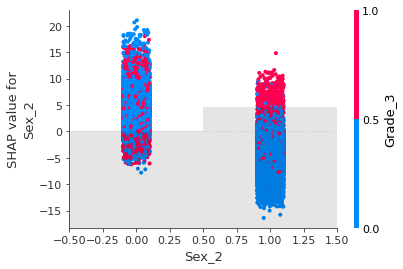

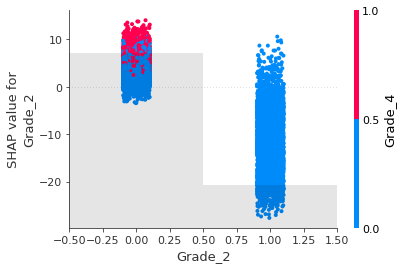

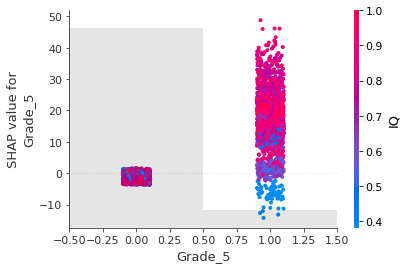

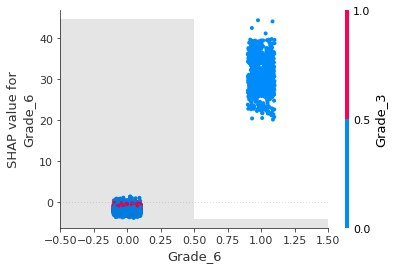

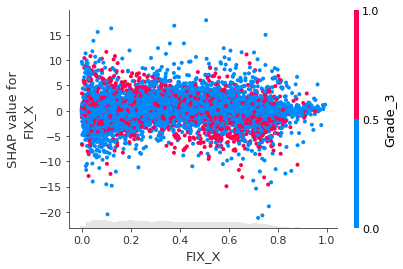

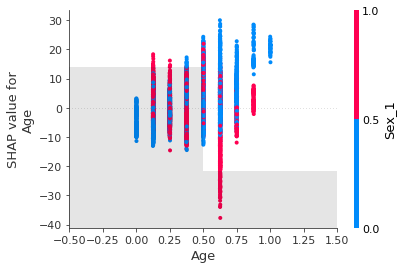

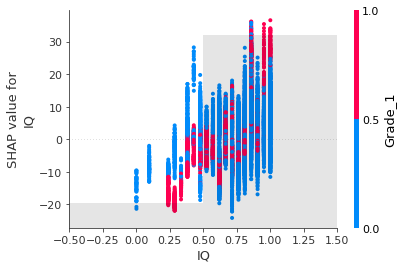

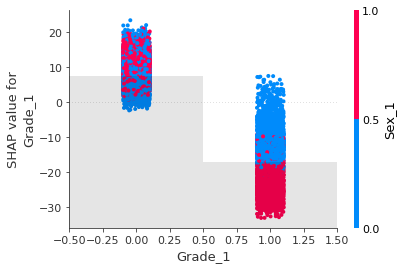

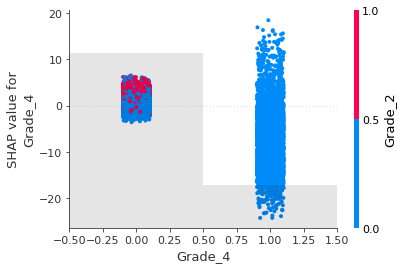

In [69]:
for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)



- 


## Individual force plots of 3 randomly selected samples of each class


In [81]:
y_org.shape, y_test.shape

((225350, 2), (22535,))

In [71]:



normals = np.where(y_org.Group == 1)[0]
at_risks = np.where(y_org.Group == 2)[0]
dyslexics = np.where(y_org.Group == 3)[0]



n_size = 5
np.random.seed(43)
normals_rnd = np.random.choice(normals, n_size)
at_risks_rnd = np.random.choice(at_risks, n_size)
dyslexics_rnd = np.random.choice(dyslexics, n_size)




In [72]:
normals_rnd



array([ 14148,  61911, 204500, 208953,  94570])

In [73]:
at_risks_rnd


array([200153, 103243, 168683, 200374, 109162])

In [74]:

dyslexics_rnd


array([109080, 154445,  89708, 153996,  29191])

IndexError: index 61911 is out of bounds for axis 0 with size 22535

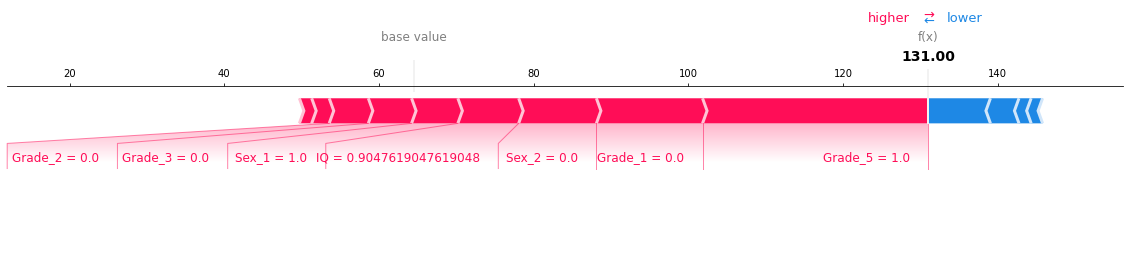

In [75]:
for n in normals_rnd:
    shap.plots.force(shap_values[n], show=False, matplotlib=True)
    
    

In [76]:
for r in at_risks_rnd:
    shap.plots.force(shap_values[r], show=False, matplotlib=True)
    
    

IndexError: index 200153 is out of bounds for axis 0 with size 22535

In [77]:
for d in dyslexics_rnd:
    shap.plots.force(shap_values[d], show=False, matplotlib=True)
    
    

IndexError: index 109080 is out of bounds for axis 0 with size 22535